In [ ]:
# default_exp multiscale_flow_embedder
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2
device

device(type='cpu')

# 05c Multiscale Flow Embeddings with a Grid
The problem with the Diffusion Flow Embedder (05b) is that, although it minimizes the loss quite well, achieving 0 cost only requires the network to replicate the graph's *affinity* matrix within the embedding. Consequently, the embedding only preserves near neighbors; like tSNE, it willfully distorts global structure.

This manifests in, for example 05b05 and 05b05a, where we see that the spiral (and the swiss roll) are not *unrolled*, as we'd like -- but are either left coiled, as in their projections, or wrapped oddly. The affinity matrices of the embeddings are beautiful. They have no way of telling how weird the global structure is. 

As a result, the flows learnt by the method are unnecessarily complex, and tend to wrap around the manifold. The flows are only used for near neighbor connectivity, hence there is no incentive to learn anything that makes sense in long ranges.

This notebook is motivated by a suspicion that these effects can be greatly lessened with two novel additions:
1. *multiscale* diffusion probability comparisons  -- between $P_{graph}^t$ and $P_{embedding}^t$ for several values of $t$, but only in which
2. a *grid* connects points in the embedding space in a way the ambient points aren't connected.

Much of the machinery for this was already developed in 05b. We need only introduce the grid, and a multiscale loss.

I'm additionally going to try to make the class as *modular* as possible, to avoid the syndrome of doing everything within one giant code block with a class that has dozens of functions.

In [ ]:
# export
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset, smoothness_of_vector_field
def compute_grid(X,grid_width=20):
  """ Returns a grid of points which bounds the points X. 
  The grid has 'grid_width' dots in both length and width.
  Accepts X, tensor of shape n x 2
  Returns tensor of shape grid_width^2 x 2"""
  # TODO: This currently only supports 
  # find support of points
  minx = float(torch.min(X[:,0])-1) # TODO: use torch.min, try without detach
  maxx = float(torch.max(X[:,0])+1)
  miny = float(torch.min(X[:,1])-1)
  maxy = float(torch.max(X[:,1])+1)
  # form grid around points
  x, y = torch.meshgrid(torch.linspace(minx,maxx,steps=grid_width),torch.linspace(miny,maxy,steps=grid_width))
  xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()
  xy_t = xy_t.reshape(grid_width**2,2).detach()
  return xy_t

A cornerstone of this method will be the powering of the diffusion matrix, which must intersperse jumping between points in the dataset and in the surrounding grid. Traditional matrix powering will do, provided we add the grid points to the dataset before powering, and then take them out afterwards.

In [ ]:
# export
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset, GaussianVectorField
import torch.nn.functional as F
def diffusion_matrix_with_grid_points(X, grid, flow_function, t, sigma,flow_strength):
  n_points = X.shape[0]
  # combine the points and the grid
  points_and_grid = torch.concat([X,grid],dim=0)
  # get flows at each point
  flow_per_point = flow_function(points_and_grid)
  # take a diffusion matrix
  A = affinity_matrix_from_pointset_to_pointset(points_and_grid,points_and_grid, flows = flow_per_point, sigma = sigma, flow_strength=flow_strength)
  P = F.normalize(A, p=1, dim=-1)
  # TODO: Should we remove self affinities? Probably not, as lazy random walks are advantageous when powering
  # Power the matrix to t steps
  Pt = torch.matrix_power(P,t)
  # Recover the transition probabilities between the points, and renormalize them
  Pt_points = Pt[:n_points,:n_points]
  # Pt_points = torch.diag(1/Pt_points.sum(1)) @ Pt_points
  Pt_points = F.normalize(Pt_points, p=1, dim=1)
  # return diffusion probs between points
  return Pt_points

In [ ]:
A = torch.tensor([[1,2],[3,4],[5,6]])
B = torch.rand(5,2)
K = GaussianVectorField(2,25,device=torch.device('cpu'))
out = diffusion_matrix_with_grid_points(A,B,K,1, 0.5, 4)
out

tensor([[9.9994e-01, 5.8019e-05, 2.0269e-07],
        [2.2627e-03, 9.9242e-01, 5.3125e-03],
        [1.2161e-05, 3.4812e-03, 9.9651e-01]], grad_fn=<DivBackward0>)

## General embedding matrix
The architecture should support modular swapping of point embedding methods. A few of these include:
1. Feedforward embedder (paired with a decoder)
2. Learnable initialized points (random, or to a prior embedding initialization, like DMaps, UMAP, PHATE...)
3. Fixed initializations, if we want the flow to contort itself to the initialization
This will take the shape of swappable "embedder" classes, which can be supplied as input to the network.

For example, here is the simple FF net we use in the autoencoder:

In [ ]:
# export
import torch.nn as nn
from collections import OrderedDict
class FeedForwardReLU(nn.Module):
  def __init__(self, shape):
    super(FeedForwardReLU, self).__init__()
    d_len = len(shape)*2
    d = OrderedDict()
    d[str(0)] = nn.Linear(shape[0], shape[1])
    for i in range(1,d_len-3):
        if i%2 == 1:
            d[str(i)] = nn.LeakyReLU()
        else:
            d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
    # create MLP
    self.FA = nn.Sequential(d)
  def forward(self, X):
    return self.FA(X)

In [ ]:
fa = FeedForwardReLU(shape=[2,3,4,5,6,5,4,3,2])
fa

FeedForwardReLU(
  (FA): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=3, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=4, out_features=5, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=5, out_features=6, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=6, out_features=5, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=5, out_features=4, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=4, out_features=3, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [ ]:
# export
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from directed_graphs.diffusion_flow_embedding import GaussianVectorField, smoothness_of_vector_field, FlowArtist
from directed_graphs.diffusion_flow_embedding import diffusion_map_loss, flow_cosine_loss
class MultiscaleDiffusionFlowEmbedder(torch.nn.Module):
	def __init__(self, 
							X, 
							flows, 
							ts = (1,2,4,8), 
							sigma_graph = 0.5, 
							sigma_embedding=0.5, 
							flow_strength_graph=5, 
							flow_strength_embedding=5, 
							embedding_dimension=2, 
							learning_rate = 1e-3,
							flow_artist = "ReLU",
							flow_artist_shape = (2,4,8,4,2),
							num_flow_gaussians = 25,
							embedder = FeedForwardReLU(shape=(3,4,8,4,2)),
							decoder = FeedForwardReLU(shape=(2,4,8,4,3)),
							labels = None,   
							loss_weights = {
								"diffusion":1,
								"smoothness":0,
								"reconstruction":0,
								"diffusion map regularization":0,
								"flow cosine loss": 0,
							},
							device=torch.device('cpu'),
							):
		# initialize parameters
		super(MultiscaleDiffusionFlowEmbedder, self).__init__()
		self.X = X
		self.ground_truth_flows = flows
		self.ts = ts
		self.sigma_embedding = sigma_embedding
		self.sigma_graph = sigma_graph
		self.nnodes = X.shape[0]
		self.data_dimension = X.shape[1]
		
		self.eps = 0.001
		self.loss_weights = loss_weights
		self.labels = labels
		self.flow_strength = torch.tensor(flow_strength_embedding).float()
		self.embedding_dimension = embedding_dimension
		# set device (used for shuffling points around during visualization)
		self.device = device
		# Used for 
		self.losses = {}
		for k in self.loss_weights.keys():
			self.losses[k] = []
		
		self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph,flow_strength=flow_strength_graph)
		self.P_graph = F.normalize(self.P_graph, p=1, dim=1)
		# torch.diag(1/self.P_graph.sum(axis=1)) @ self.P_graph
		# compute matrix powers 
		# TODO: Could reuse previous powers to speed this up
		self.P_graph_ts = [torch.matrix_power(self.P_graph,t) for t in self.ts]
		self.P_embedding_ts = [None for i in self.ts]
		# Flow field
		self.FlowArtist = FlowArtist(flow_artist, dim=self.embedding_dimension, num_gauss = num_flow_gaussians, shape = flow_artist_shape, device = self.device).to(self.device)

		# Autoencoder to embed the points into a low dimension
		self.embedder = embedder.to(self.device)
		if decoder is not None:
			self.decoder = decoder.to(self.device)
		else:
			self.decoder = None

		# training ops
		self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
		self.MSE = nn.MSELoss()
		self.epsilon = 1e-6 # set zeros to eps
		self.optim = torch.optim.Adam(self.parameters(), lr = learning_rate)
									
	def diffusion_loss(self):
		# compute grid around points
		self.grid = compute_grid(self.embedded_points).to(self.device)
		# normalize embedded points to lie within -self.embedding_bounds, self.embedding_bounds
		# if any are trying to escape, constrain them to lie on the edges
		# self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])
		# self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])
		# compute embedding diffusion matrix, using including diffusion to grid points
		for i,t in enumerate(self.ts):
			self.P_embedding_ts[i] = diffusion_matrix_with_grid_points(X = self.embedded_points, grid=self.grid, flow_function = self.FlowArtist, t = t, sigma = self.sigma_embedding, flow_strength=self.flow_strength)
			# set any affinities of zero to a very small amount, to prevent the KL divergence from becoming infinite.
			self.P_embedding_ts[i][self.P_embedding_ts[i] == 0] = self.epsilon
		# take KL divergence between P embedding ts and P graph ts
		diffusion_loss = 0
		for i in range(len(self.ts)):
			log_P_embedding_t = torch.log(self.P_embedding_ts[i])
			if log_P_embedding_t.is_sparse:
				diffusion_loss_for_t = self.KLD(log_P_embedding_t.to_dense(),self.P_graph_ts[i].to_dense())
			else:
				diffusion_loss_for_t = self.KLD(log_P_embedding_t,self.P_graph_ts[i])
			diffusion_loss += (2**(-i))*diffusion_loss_for_t
			print(f"Diffusion loss {i} is {diffusion_loss}")
		self.losses['diffusion'].append(diffusion_loss.detach().cpu().float())
		if diffusion_loss.isnan():
			raise NotImplementedError
		return diffusion_loss

	def loss(self):
		# embed points
		self.embedded_points = self.embedder(self.X)
		# compute diffusion loss on embedded points
		if self.diffusion_loss != 0:
			diffusion_loss = self.diffusion_loss()
		else:
			diffusion_loss = 0
		# compute autoencoder loss
		if self.decoder is not None:
			X_reconstructed = self.decoder(self.embedded_points)
			reconstruction_loss = self.MSE(X_reconstructed, self.X)
			# self.losses['reconstruction'].append(reconstruction_loss.detach().cpu().float())
		else:
			reconstruction_loss = 0
		# regularizations
		if self.loss_weights['smoothness'] != 0:
			smoothness_loss = smoothness_of_vector_field(self.embedded_points,self.FlowArtist,device=self.device,grid_width=20)
			# self.losses['smoothness'].append(smoothness_loss.detach().cpu().float())
		else:
			smoothness_loss = 0

		if self.loss_weights['diffusion map regularization'] != 0:
			diffmap_loss = diffusion_map_loss(self.P_graph_ts[0], self.embedded_points)
			# self.losses['diffusion map regularization'].append(diffmap_loss.detach().cpu().float())
		else:
			diffmap_loss = 0
		
		if self.loss_weights['flow cosine loss'] != 0:
			flow_loss = flow_cosine_loss(self.embedded_points, self.ground_truth_flows, self.FlowArtist(self.embedded_points))
			# self.losses['flow cosine loss'].append(smoothness_loss.detach().cpu().float())
		else:
			flow_loss = 0

		cost = self.loss_weights['diffusion']*diffusion_loss 
		+ self.loss_weights['reconstruction']*reconstruction_loss 
		+ self.loss_weights['smoothness']*smoothness_loss
		+ self.loss_weights['diffusion map regularization']*diffmap_loss
		+ self.loss_weights['flow cosine loss']*flow_loss
		return cost

	def visualize_points(self, labels = None):
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		if labels is None:
			labels = self.labels
		uv = self.FlowArtist(self.grid).detach().cpu()
		u = uv[:,0].cpu()
		v = uv[:,1].cpu()
		x = self.grid.detach().cpu()[:,0]
		y = self.grid.detach().cpu()[:,1]
		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		if labels is not None:
			sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
			plt.legend()
		else:
			sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu())
		plt.suptitle("Flow Embedding")
		plt.quiver(x,y,u,v)
		# Display all open figures.
		plt.show()
		
		  
	def visualize_loss(self, loss_type = "total"):
		# diffusion_loss,reconstruction_loss, smoothness_loss
		x = []
		losses = {}
		losses["total"] = []
		losses["diffusion"] = []
		losses["reconstruction"] = []
		losses["smoothness"] = []
		for i in range(len(self.losses)):
			x.append(i)
			losses["diffusion"].append(self.losses[i][0].detach().cpu().numpy())
			losses["reconstruction"].append(self.losses[i][1].detach().cpu().numpy())
			losses["smoothness"].append(self.losses[i][2].detach().cpu().numpy())
			losses["total"].append(losses["diffusion"][i] + losses["reconstruction"][i] + losses["smoothness"][i])
		
		if loss_type == "all":
			plt.plot(x, losses["total"])
			plt.plot(x, losses["diffusion"])
			plt.plot(x, losses["reconstruction"])
			plt.plot(x, losses["smoothness"])
			plt.legend(('total', 'diffusion', 'reconstruction', 'smoothness'), loc='upper right')
			plt.title("loss")
		else:
			plt.plot(x, losses[loss_type])
			plt.title(loss_type)
				
				
	def visualize_diffusion_matrices(self):
		fig, axs = plt.subplots(3,2, figsize=(10,15))
		axs[0][0].set_title(f"Ambient $P^{self.ts[0]}$")
		axs[0][0].imshow(self.P_graph_ts[0].detach().cpu().numpy())
		axs[0][1].set_title(f"Embedding $P^{self.ts[0]}$")
		axs[0][1].imshow(self.P_embedding_ts[0].detach().cpu().numpy())
		
		axs[1][0].set_title(f"Ambient $P^{self.ts[1]}$")
		axs[1][0].imshow(self.P_graph_ts[1].detach().cpu().numpy())
		axs[1][1].set_title(f"Embedding $P^{self.ts[1]}$")
		axs[1][1].imshow(self.P_embedding_ts[1].detach().cpu().numpy())

		axs[2][0].set_title(f"Ambient $P^{self.ts[2]}$")
		axs[2][0].imshow(self.P_graph_ts[2].detach().cpu().numpy())
		axs[2][1].set_title(f"Embedding $P^{self.ts[2]}$")
		axs[2][1].imshow(self.P_embedding_ts[2].detach().cpu().numpy())

		plt.show()

	def fit(self,n_steps = 1000):
		# train Flow Embedder on the provided graph
		self.train()
		# self.weight_of_flow = 0
		for step in trange(n_steps):
			# if step == 100:
			# 	self.weight_of_flow = 1
			# if step == 200:
			# 	self.weight_of_flow = 0.5
			self.optim.zero_grad()
			# compute loss
			loss = self.loss()
			if loss.isnan():
				print("Final loss was nan")
				raise NotImplementedError
			# print("loss is ",loss)
			# compute gradient and step backwards
			loss.backward()
			self.optim.step()
			if step % 100 == 0:
				print(f"EPOCH {step}. Loss {loss}. Flow strength {self.flow_strength}. Heatmap of P embedding is ")
				self.visualize_diffusion_matrices()
				self.visualize_points()
			# TODO: Criteria to automatically end training
		print("Exiting training with loss ",loss)
		return self.embedded_points

# Basic Tests/Sanity Checks
More comprehensive explorations will be in the notebooks under 05c. For now, we ensure the network *works*.

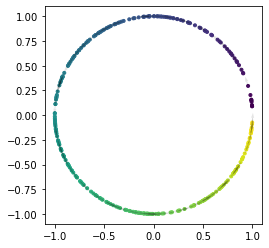

In [ ]:
from directed_graphs.datasets import directed_circle, directed_cylinder, directed_spiral, directed_swiss_roll, directed_spiral_uniform, directed_swiss_roll_uniform
from directed_graphs.datasets import plot_directed_2d, plot_directed_3d
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
import torch
import numpy as np
X, flow, labels = directed_circle(num_nodes=300, radius=1)
plot_directed_2d(X, flow, labels)
X = torch.tensor(X).float().to(device)
flow = torch.tensor(flow).float().to(device)

In [ ]:
MFE = MultiscaleDiffusionFlowEmbedder(X, flow, device=device).to(device)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/adjourner/miniforge3/envs/pyg_from_source/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1655104150265/work/aten/src/ATen/native/TensorShape.cpp:2890.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Diffusion loss 0 is 4.443930149078369
Diffusion loss 1 is 6.374485969543457
Diffusion loss 2 is 6.932337760925293
Diffusion loss 3 is 7.05295467376709
EPOCH 0. Loss 7.05295467376709. Flow strength 5.0. Heatmap of P embedding is 


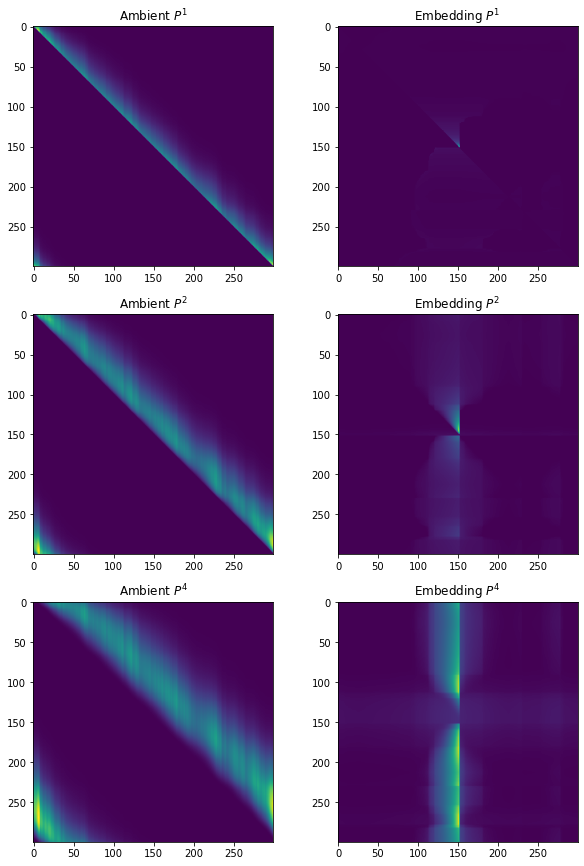

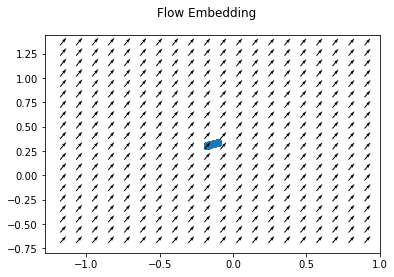

 20%|██        | 2/10 [00:01<00:07,  1.10it/s]

Diffusion loss 0 is 4.397401809692383
Diffusion loss 1 is 6.304996490478516
Diffusion loss 2 is 6.8596510887146
Diffusion loss 3 is 6.980245590209961


 30%|███       | 3/10 [00:02<00:05,  1.28it/s]

Diffusion loss 0 is 4.3409743309021
Diffusion loss 1 is 6.230025768280029
Diffusion loss 2 is 6.782107353210449
Diffusion loss 3 is 6.902767181396484


 40%|████      | 4/10 [00:03<00:04,  1.34it/s]

Diffusion loss 0 is 4.294564723968506
Diffusion loss 1 is 6.159804821014404
Diffusion loss 2 is 6.70935583114624
Diffusion loss 3 is 6.830083847045898


 50%|█████     | 5/10 [00:03<00:03,  1.36it/s]

Diffusion loss 0 is 4.234472274780273
Diffusion loss 1 is 6.071816444396973
Diffusion loss 2 is 6.6182355880737305
Diffusion loss 3 is 6.739051818847656


 60%|██████    | 6/10 [00:04<00:02,  1.37it/s]

Diffusion loss 0 is 4.185101509094238
Diffusion loss 1 is 6.003979682922363
Diffusion loss 2 is 6.547656536102295
Diffusion loss 3 is 6.668618679046631


 70%|███████   | 7/10 [00:05<00:02,  1.43it/s]

Diffusion loss 0 is 4.15395975112915
Diffusion loss 1 is 5.956161022186279
Diffusion loss 2 is 6.497410774230957
Diffusion loss 3 is 6.61846923828125


 80%|████████  | 8/10 [00:05<00:01,  1.45it/s]

Diffusion loss 0 is 4.124948501586914
Diffusion loss 1 is 5.912533760070801
Diffusion loss 2 is 6.45113468170166
Diffusion loss 3 is 6.572256088256836


 90%|█████████ | 9/10 [00:06<00:00,  1.45it/s]

Diffusion loss 0 is 4.082062244415283
Diffusion loss 1 is 5.8491926193237305
Diffusion loss 2 is 6.385311126708984
Diffusion loss 3 is 6.506486415863037


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

Diffusion loss 0 is 4.0418548583984375
Diffusion loss 1 is 5.792097091674805
Diffusion loss 2 is 6.325092315673828
Diffusion loss 3 is 6.446310043334961
Exiting training with loss  tensor(6.4463, grad_fn=<MulBackward0>)


tensor([[-0.1828,  0.3209],
        [-0.1828,  0.3208],
        [-0.1835,  0.3206],
        [-0.1854,  0.3198],
        [-0.1863,  0.3195],
        [-0.1864,  0.3194],
        [-0.1868,  0.3193],
        [-0.1894,  0.3183],
        [-0.1941,  0.3165],
        [-0.1997,  0.3145],
        [-0.1998,  0.3144],
        [-0.2010,  0.3140],
        [-0.2026,  0.3135],
        [-0.2035,  0.3132],
        [-0.2036,  0.3132],
        [-0.2038,  0.3131],
        [-0.2045,  0.3129],
        [-0.2052,  0.3127],
        [-0.2055,  0.3126],
        [-0.2056,  0.3126],
        [-0.2059,  0.3125],
        [-0.2063,  0.3125],
        [-0.2065,  0.3125],
        [-0.2067,  0.3126],
        [-0.2067,  0.3126],
        [-0.2066,  0.3127],
        [-0.2062,  0.3131],
        [-0.2061,  0.3132],
        [-0.2054,  0.3136],
        [-0.2052,  0.3138],
        [-0.2050,  0.3139],
        [-0.2050,  0.3139],
        [-0.2043,  0.3143],
        [-0.2042,  0.3144],
        [-0.2036,  0.3148],
        [-0.2028,  0

In [ ]:
MFE.fit(n_steps=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


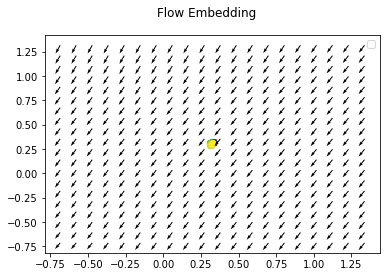

In [ ]:
MFE.visualize_points(labels=labels)

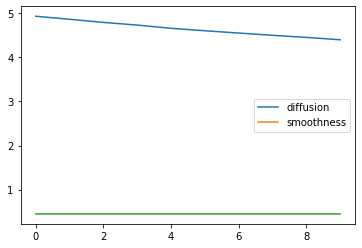

In [ ]:
plt.plot(MFE.losses["diffusion"], label = "diffusion")
plt.plot(MFE.losses["smoothness"], label = 'smoothness')
plt.plot(MFE.losses["reconstruction"])
plt.legend()

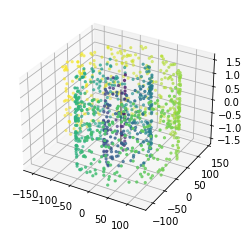

In [ ]:
X, flow, labels = directed_swiss_roll_uniform(num_nodes=1000, num_spirals=2.5, radius=10, height=3, xtilt=0, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

In [ ]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [ ]:
MFE = MultiscaleDiffusionFlowEmbedder(X, flow, device=device).to(device)


  0%|          | 0/10000 [00:00<?, ?it/s]

EPOCH 0. Loss 11.891934394836426. Flow strength 4.999000072479248. Heatmap of P embedding is 


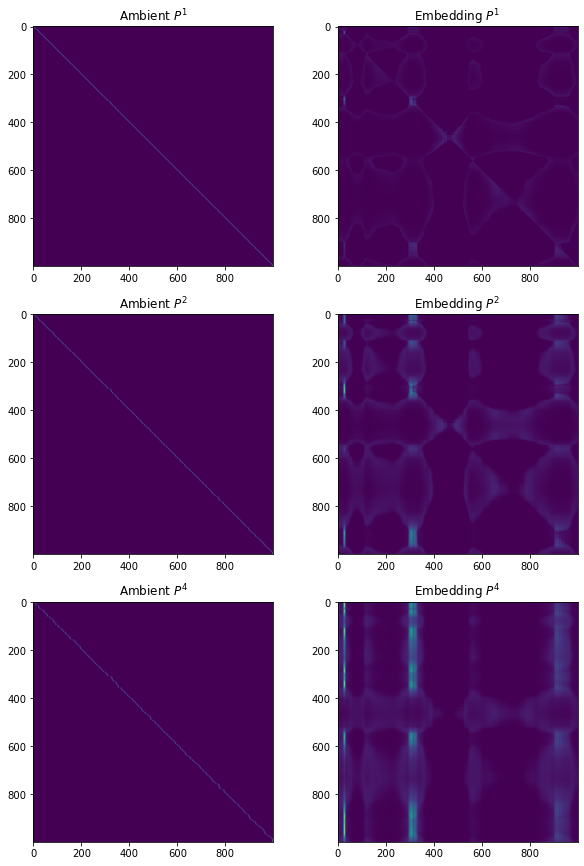

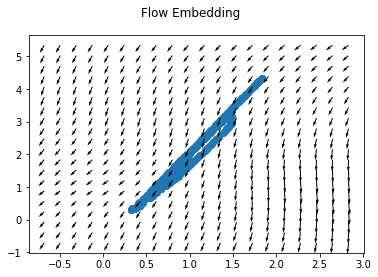

  1%|          | 100/10000 [00:15<19:12,  8.59it/s]

EPOCH 100. Loss 8.272184371948242. Flow strength 4.952264785766602. Heatmap of P embedding is 


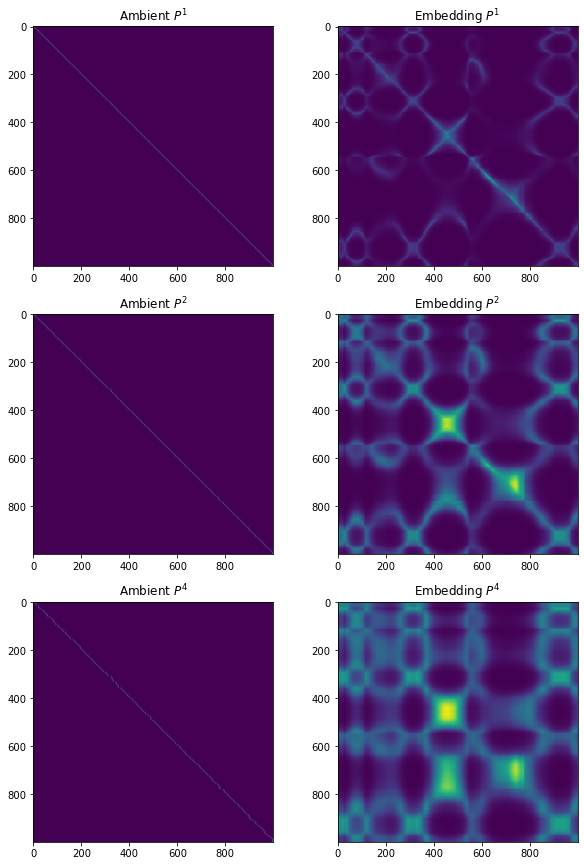

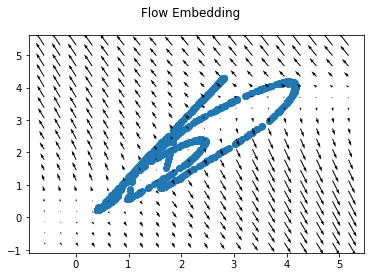

  2%|▏         | 200/10000 [00:30<26:09,  6.24it/s]  

EPOCH 200. Loss 8.326654434204102. Flow strength 4.955779552459717. Heatmap of P embedding is 


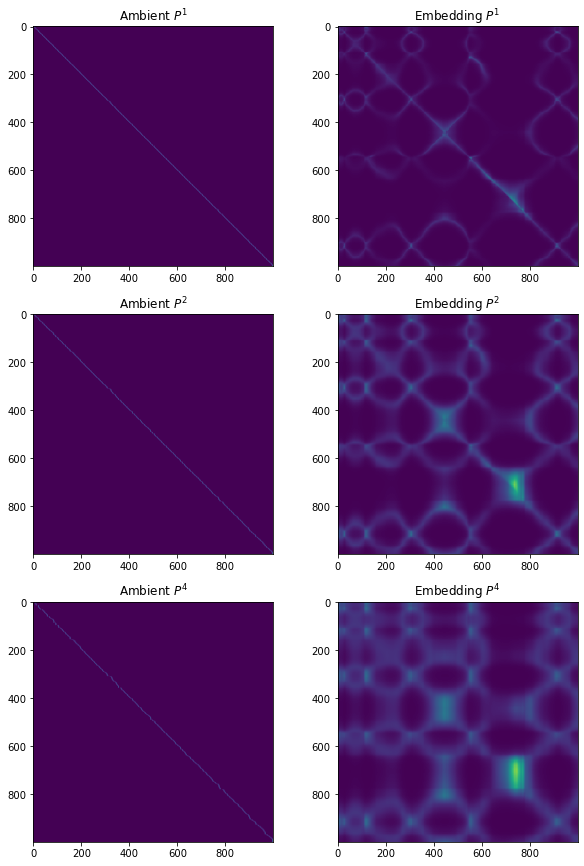

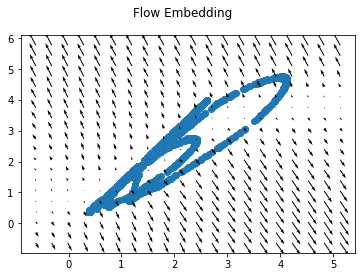

  3%|▎         | 300/10000 [00:44<22:10,  7.29it/s]  

EPOCH 300. Loss 8.010849952697754. Flow strength 4.956110954284668. Heatmap of P embedding is 


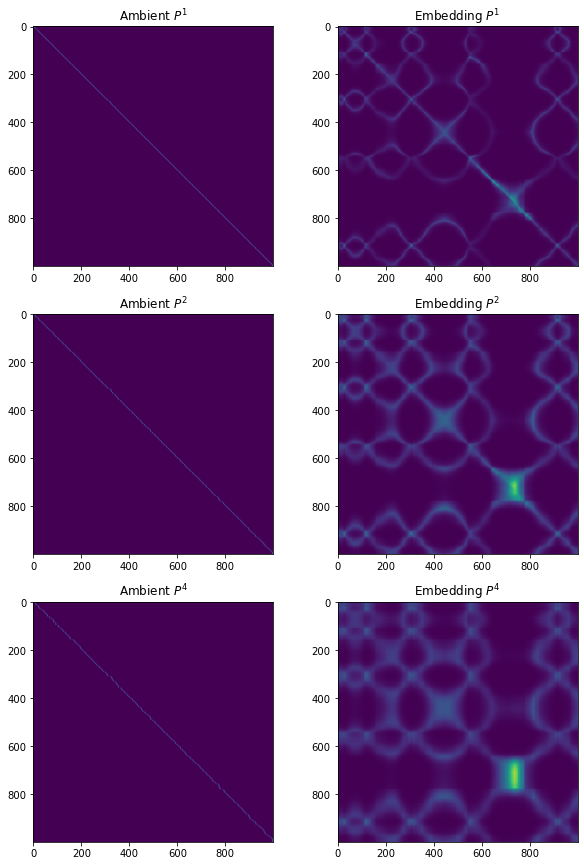

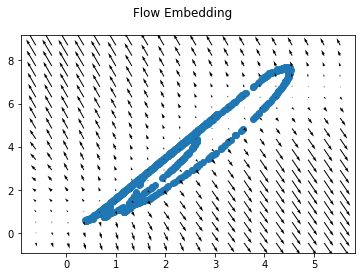

  4%|▍         | 400/10000 [00:59<22:36,  7.08it/s]  

EPOCH 400. Loss 7.801275730133057. Flow strength 4.9596638679504395. Heatmap of P embedding is 


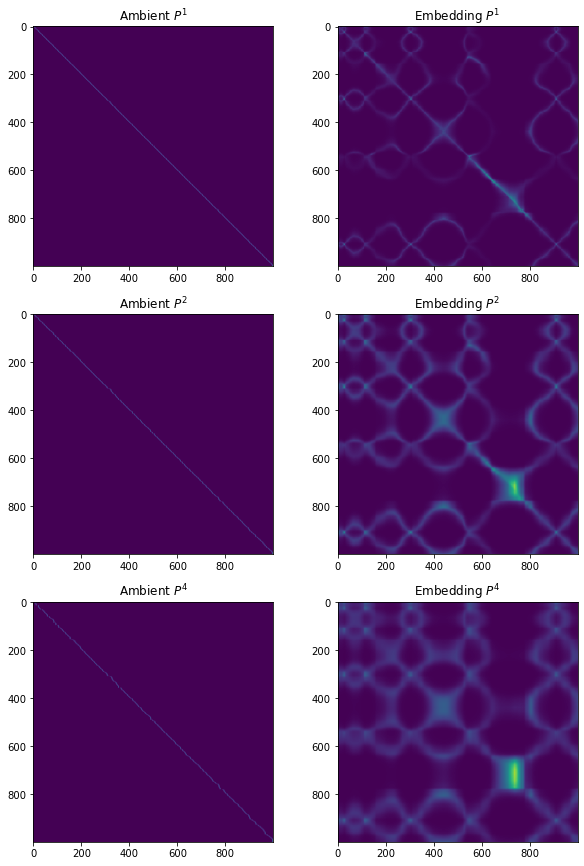

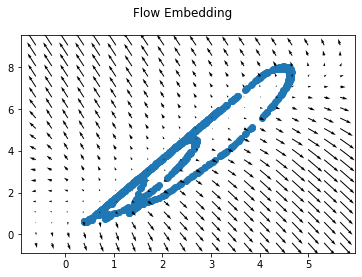

  5%|▌         | 500/10000 [01:14<21:53,  7.23it/s]  

EPOCH 500. Loss 7.280424118041992. Flow strength 4.979403018951416. Heatmap of P embedding is 


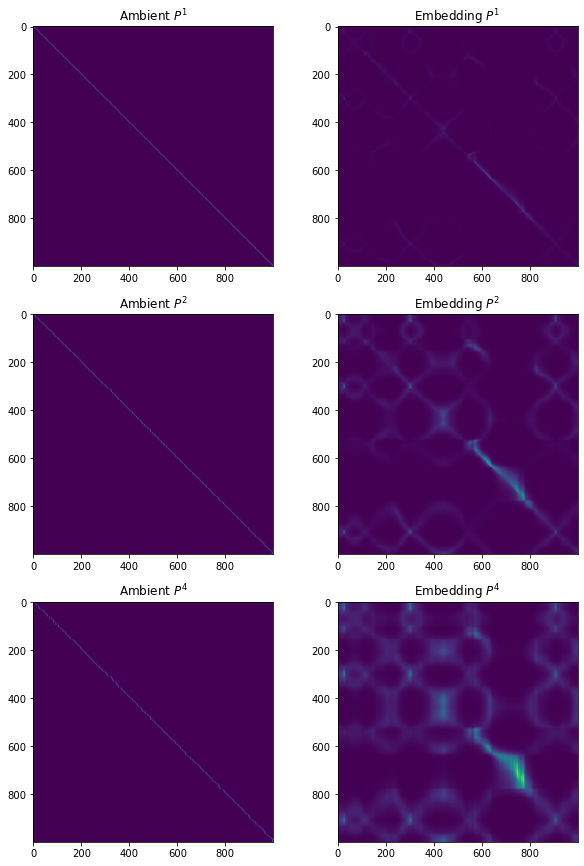

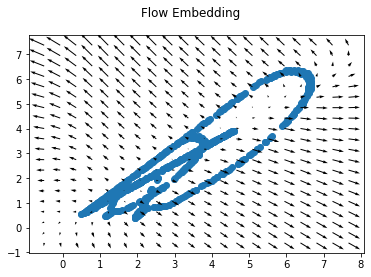

  6%|▌         | 600/10000 [01:29<22:26,  6.98it/s]  

EPOCH 600. Loss 6.438525199890137. Flow strength 4.982205867767334. Heatmap of P embedding is 


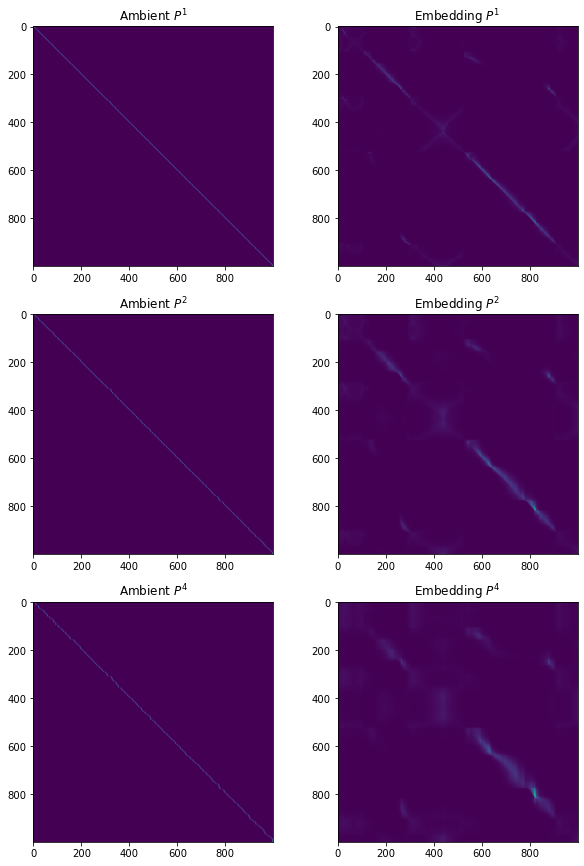

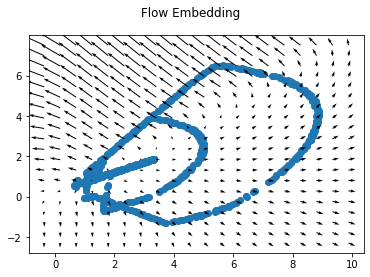

  7%|▋         | 700/10000 [01:44<23:43,  6.53it/s]  

EPOCH 700. Loss 6.5063371658325195. Flow strength 4.990403175354004. Heatmap of P embedding is 


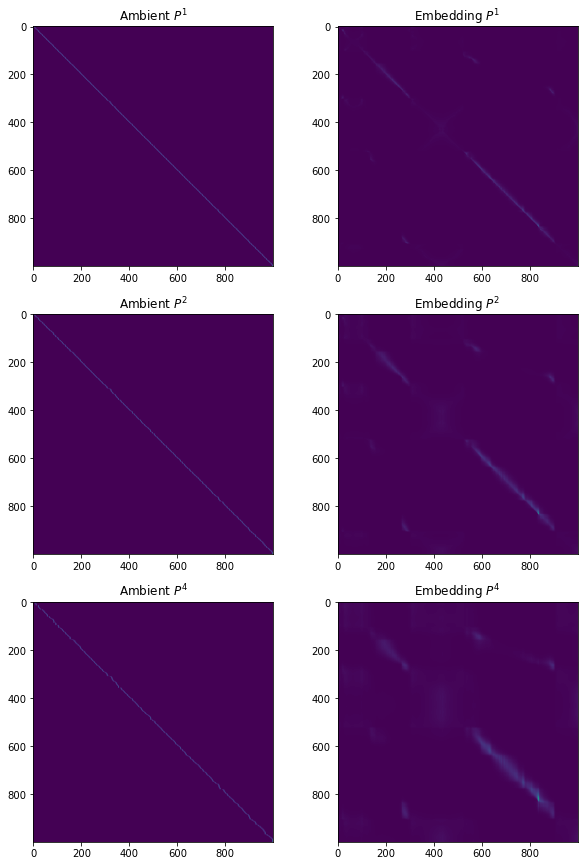

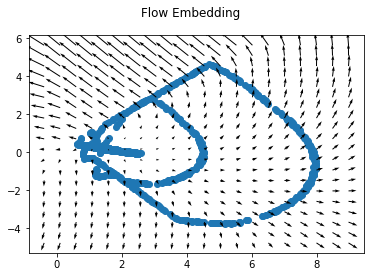

  8%|▊         | 800/10000 [01:58<17:17,  8.87it/s]  

EPOCH 800. Loss 6.906248092651367. Flow strength 4.994604110717773. Heatmap of P embedding is 


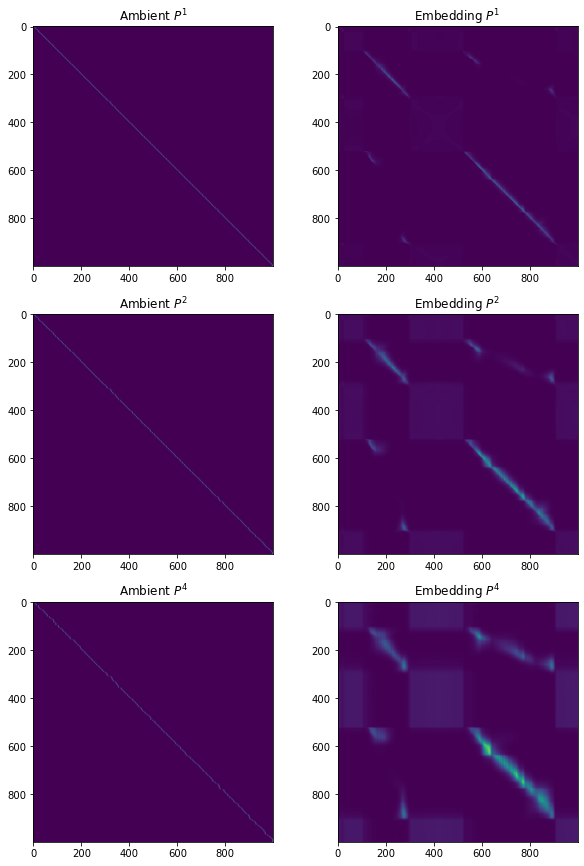

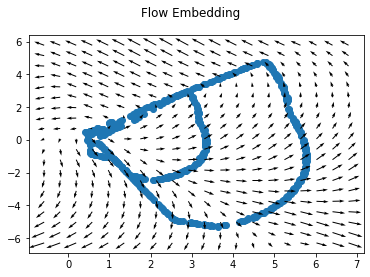

  9%|▉         | 900/10000 [02:12<24:16,  6.25it/s]  

EPOCH 900. Loss 6.449456214904785. Flow strength 4.994830131530762. Heatmap of P embedding is 


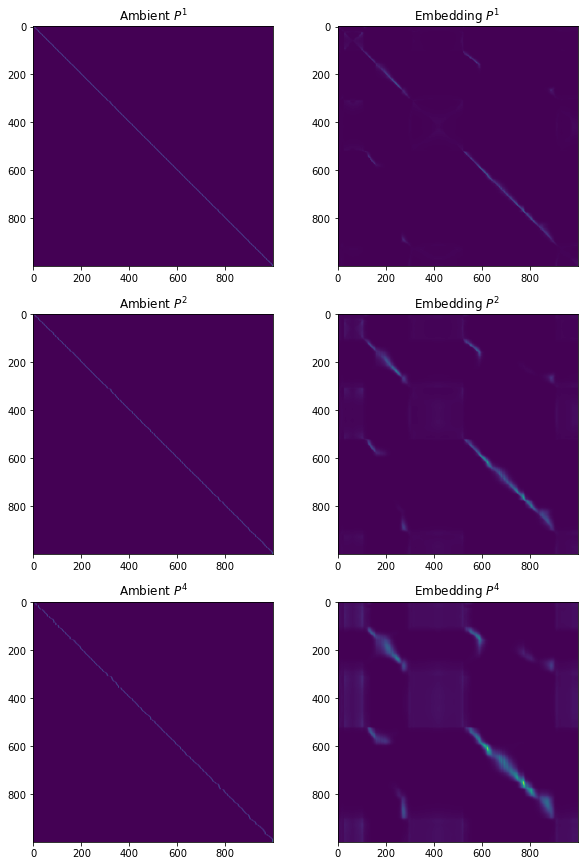

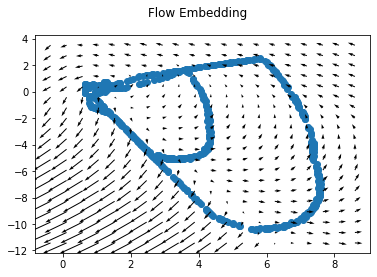

 10%|█         | 1000/10000 [02:26<20:38,  7.27it/s] 

EPOCH 1000. Loss 6.436872482299805. Flow strength 4.991913318634033. Heatmap of P embedding is 


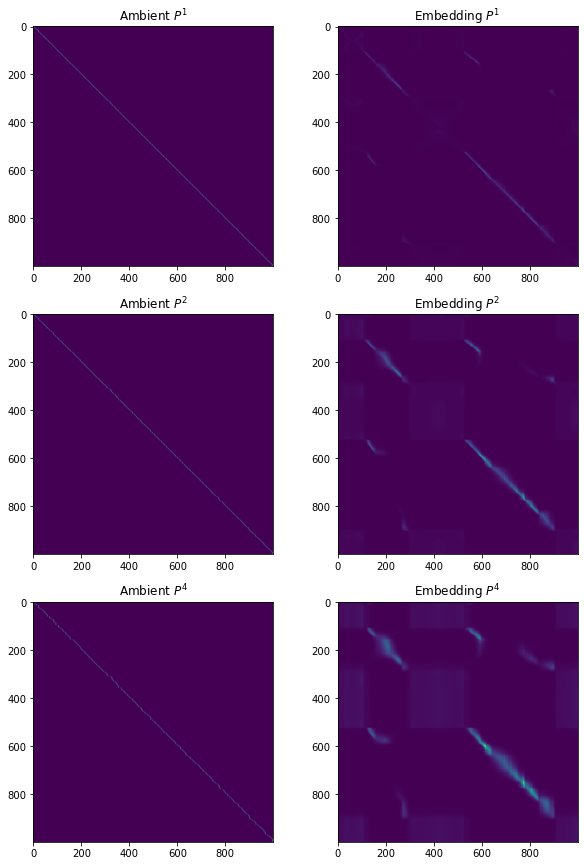

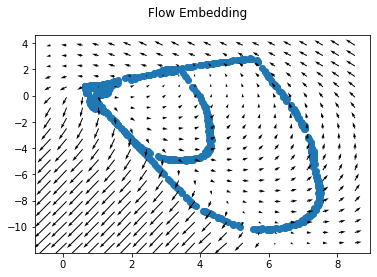

 11%|█         | 1100/10000 [02:39<16:41,  8.88it/s]  

EPOCH 1100. Loss 6.227049827575684. Flow strength 4.983253002166748. Heatmap of P embedding is 


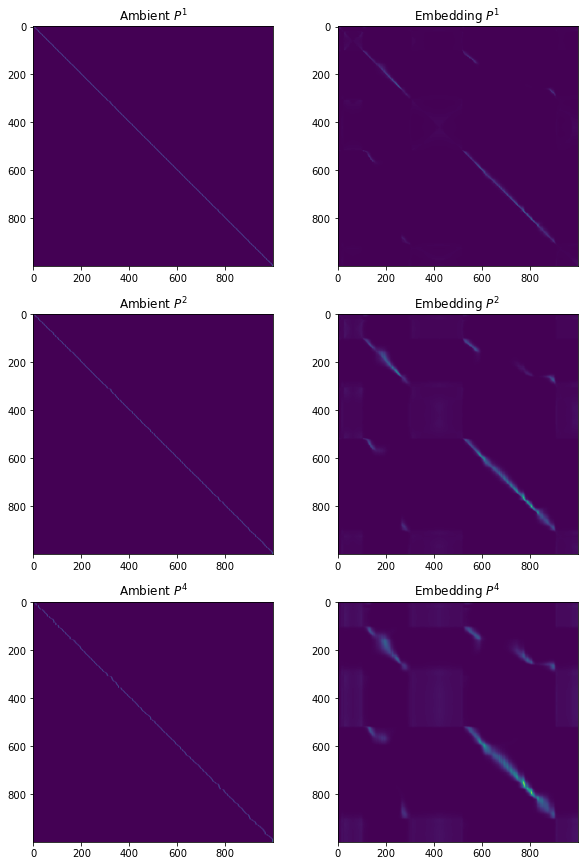

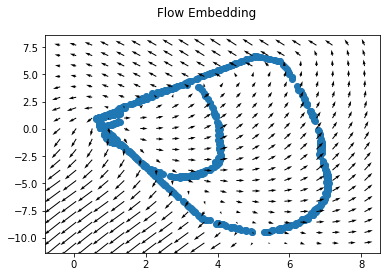

 12%|█▏        | 1200/10000 [02:51<20:18,  7.22it/s]  

EPOCH 1200. Loss 6.149223327636719. Flow strength 4.982929706573486. Heatmap of P embedding is 


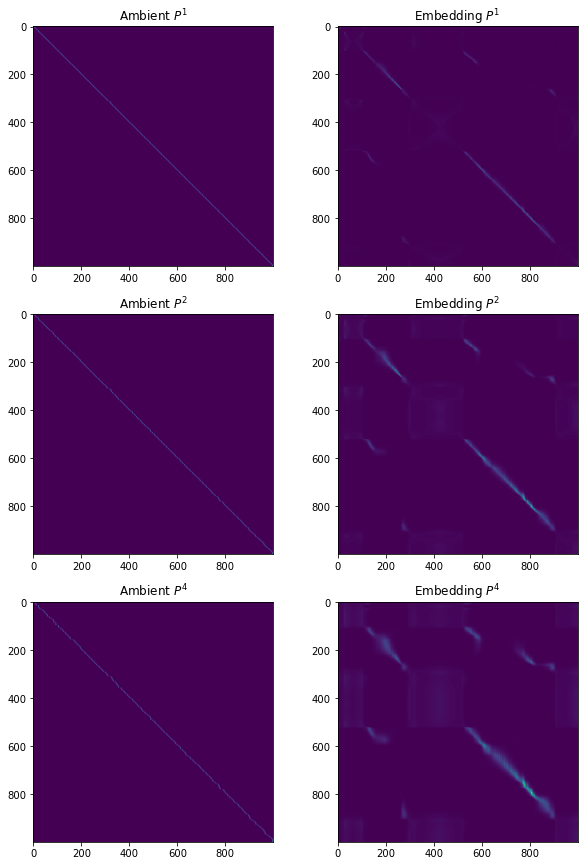

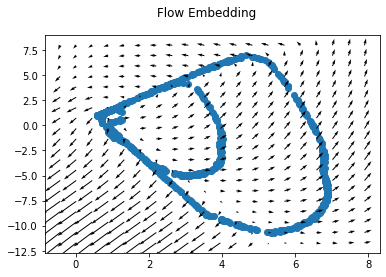

 13%|█▎        | 1300/10000 [03:06<19:53,  7.29it/s]  

EPOCH 1300. Loss 5.984847068786621. Flow strength 4.990385055541992. Heatmap of P embedding is 


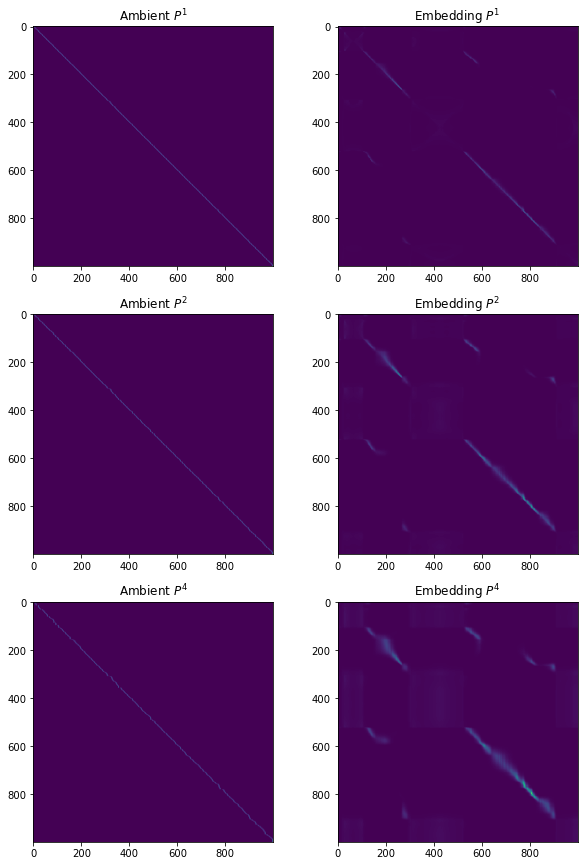

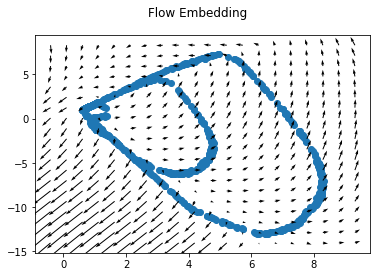

 14%|█▍        | 1400/10000 [03:20<19:42,  7.27it/s]  

EPOCH 1400. Loss 5.991268634796143. Flow strength 4.995453357696533. Heatmap of P embedding is 


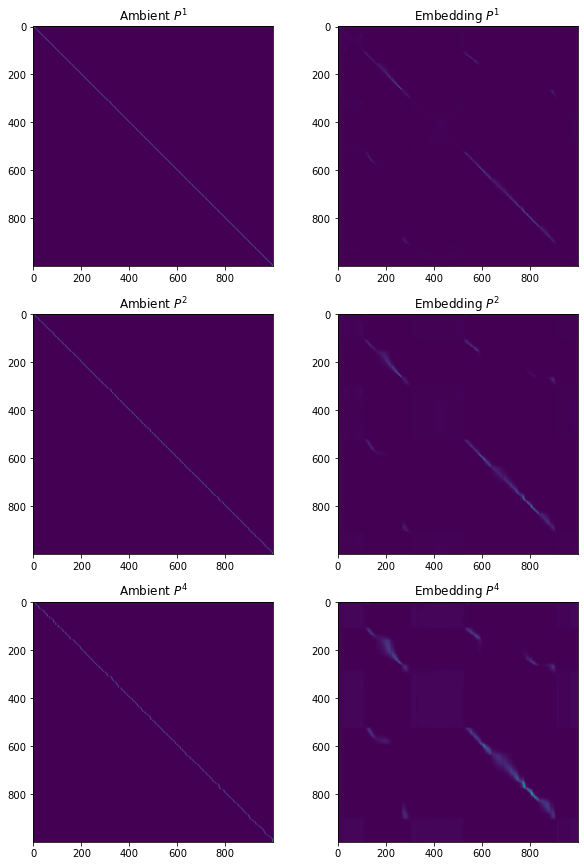

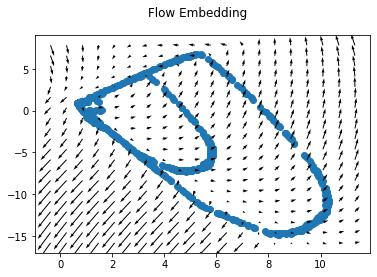

 15%|█▌        | 1500/10000 [03:35<19:28,  7.28it/s]

EPOCH 1500. Loss 5.852634906768799. Flow strength 5.002211093902588. Heatmap of P embedding is 


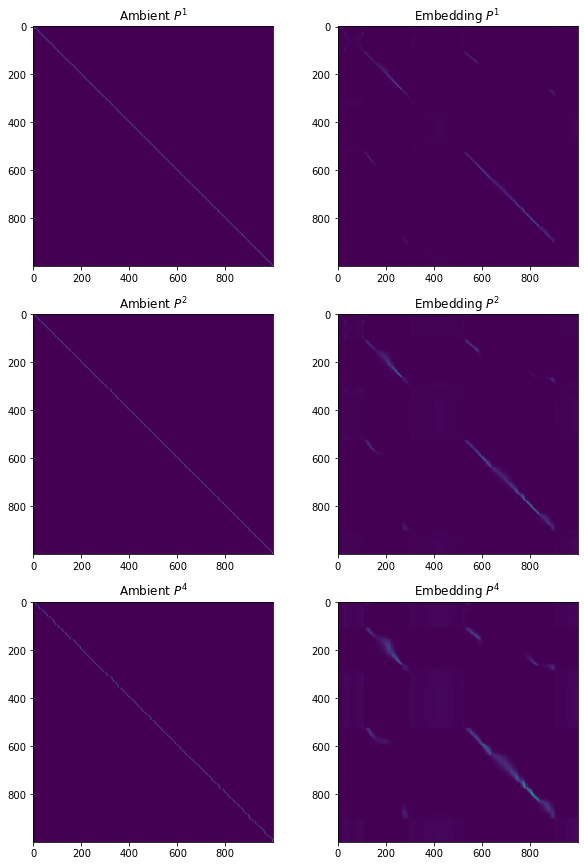

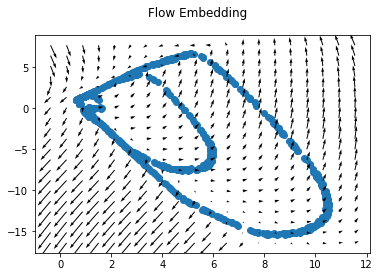

 16%|█▌        | 1600/10000 [03:50<19:15,  7.27it/s]

EPOCH 1600. Loss 5.773377895355225. Flow strength 5.013149738311768. Heatmap of P embedding is 


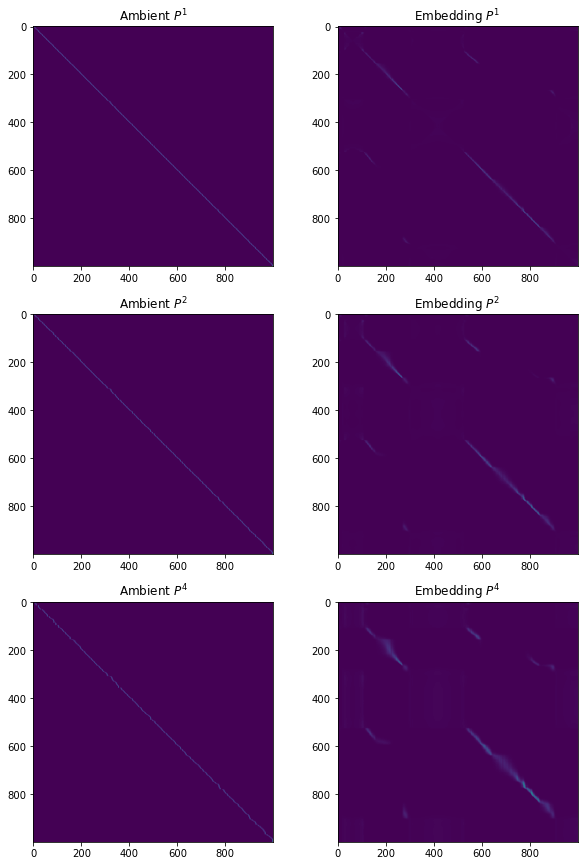

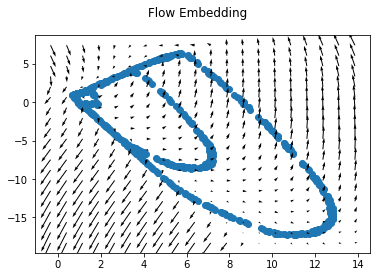

 17%|█▋        | 1700/10000 [04:04<18:34,  7.45it/s]  

EPOCH 1700. Loss 5.805696964263916. Flow strength 5.04870080947876. Heatmap of P embedding is 


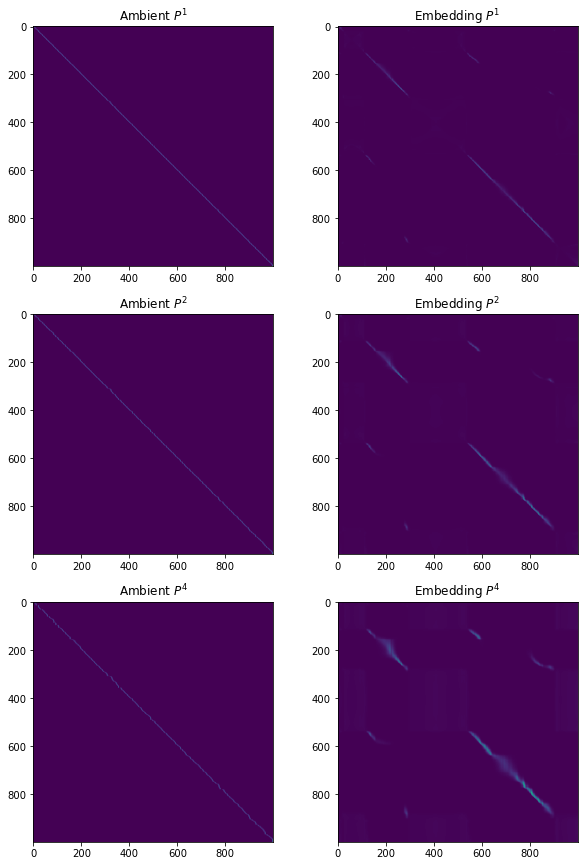

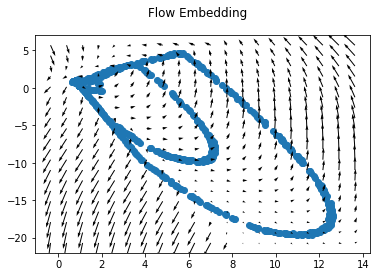

 18%|█▊        | 1800/10000 [04:19<19:17,  7.09it/s]

EPOCH 1800. Loss 5.712757110595703. Flow strength 5.038760662078857. Heatmap of P embedding is 


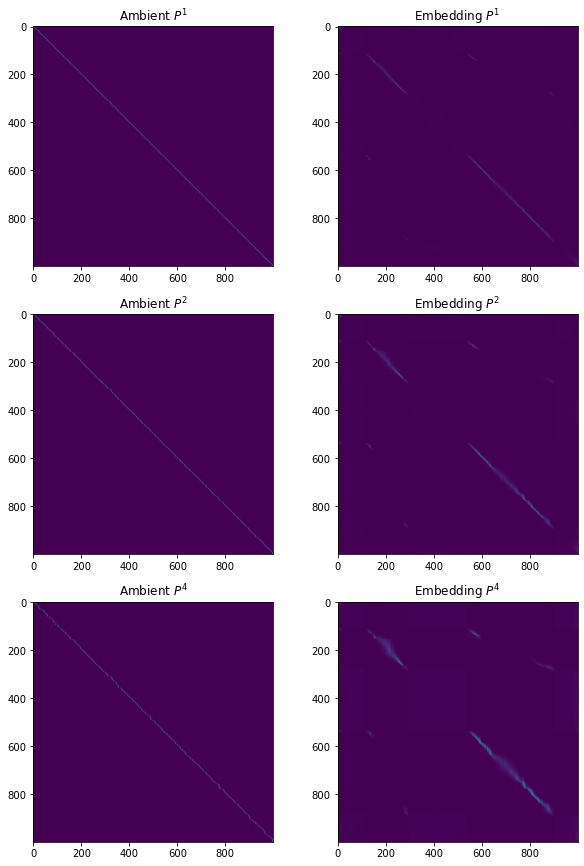

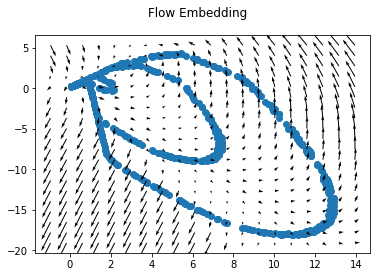

 19%|█▉        | 1900/10000 [04:33<18:37,  7.25it/s]

EPOCH 1900. Loss 5.071902751922607. Flow strength 5.019508361816406. Heatmap of P embedding is 


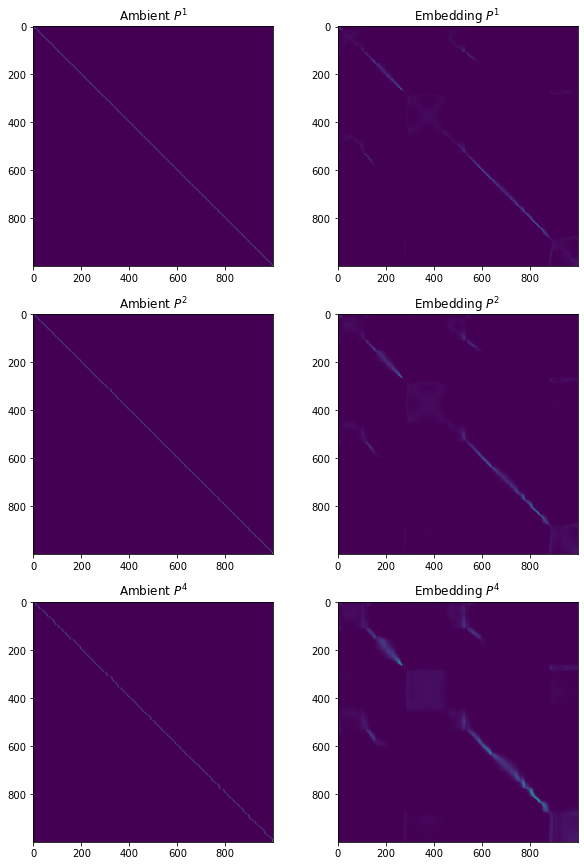

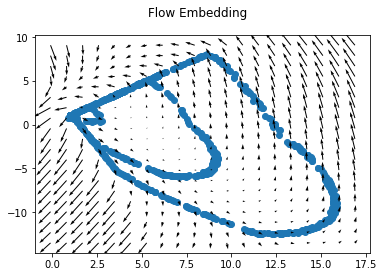

 20%|██        | 2000/10000 [04:47<17:01,  7.84it/s]

EPOCH 2000. Loss 4.494369983673096. Flow strength 5.034949779510498. Heatmap of P embedding is 


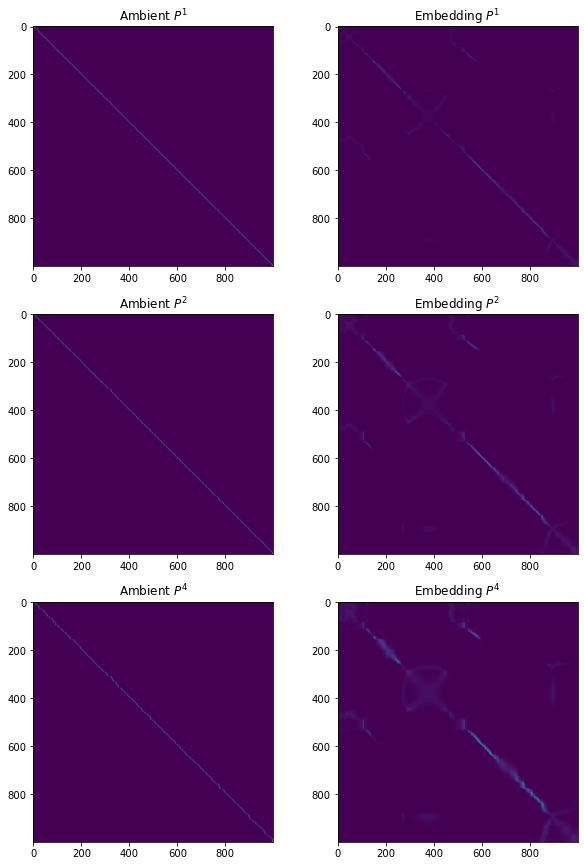

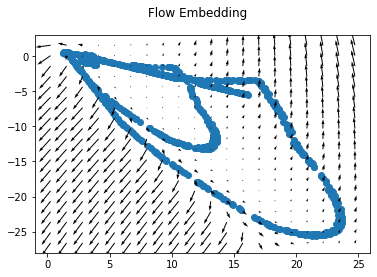

 21%|██        | 2100/10000 [05:01<21:47,  6.04it/s]

EPOCH 2100. Loss 3.9733169078826904. Flow strength 5.047738075256348. Heatmap of P embedding is 


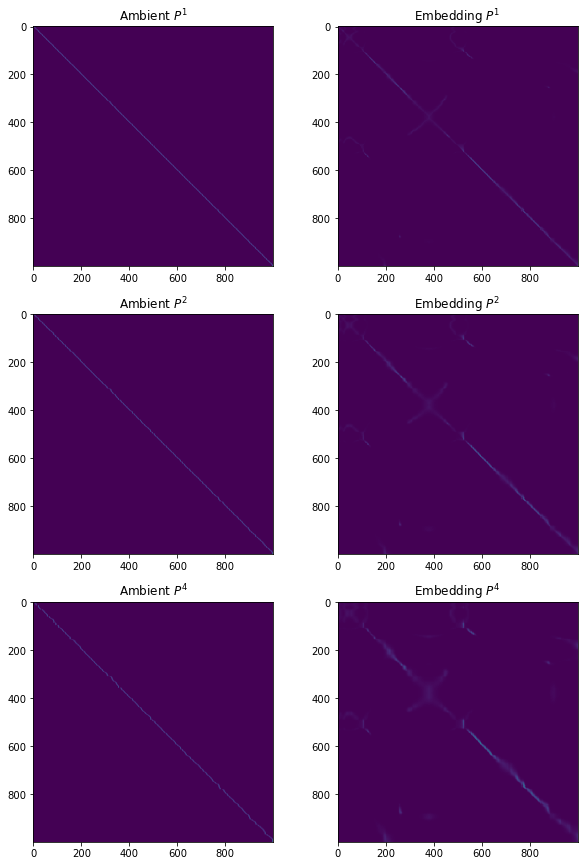

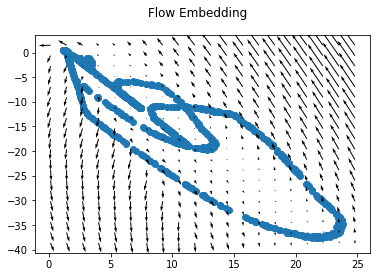

 21%|██        | 2122/10000 [05:06<18:22,  7.15it/s]  

In [ ]:
MFE.fit(n_steps=10000)